# [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/) | DLology

Read my blog post for details.

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
from time import time
from keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import metrics


In [3]:

def autoencoder_model(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [5]:
from data import load_data

x, y, mapping = load_data(10000)

Loading ./data/conll_spacy_10000.pkl
Done: (10074, 772)
{1: 'ORG', 0: 'PERSON', 2: 'GPE', 3: 'LOC'}
x: (13892, 768), y: (13892,)


In [6]:
n_clusters = len(np.unique(y))
print(f"X: {x.shape}, clusters: {n_clusters}")

X: (13892, 768), clusters: 4


## Base line K-Means clustering accuracy

In [7]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    res = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    return res

In [18]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_kmeans = kmeans.fit_predict(x)

In [19]:
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
print(f"acc: {metrics.acc(y, y_pred_kmeans)})")
print(f"NMI: {normalized_mutual_info_score(y, y_pred_kmeans)}")
print(f"AMI: {adjusted_mutual_info_score(y, y_pred_kmeans)}")

acc: 0.37446012093291103)
NMI: 0.05867710056067443
AMI: 0.058452911358412206


## Hyper-params

In [12]:
dims = [x.shape[-1], 500, 500, 2000, 50]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 1000
batch_size = 256
save_dir = './results'

In [13]:
autoencoder, encoder = autoencoder_model(dims, init=init)

In [14]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
# Image(filename='autoencoder.png') 

In [15]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
# Image(filename='encoder.png') 

## Pretrain auto-encoder

In [16]:
es_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=1e-5)

autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs, callbacks=[es_callback])
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/1000
55/55 [==============================] - 1s 6ms/step - loss: 0.1142
Epoch 2/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0951
Epoch 3/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0951
Epoch 4/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 5/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0946
Epoch 6/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0929
Epoch 7/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0907
Epoch 8/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0888
Epoch 9/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0859
Epoch 10/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 11/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0816
Epoch 12/1000
55/55 [==============================] - 0s 2ms/step - loss: 0.0784
Epoch 13/1000
55/55 [====

In [17]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Load the pre-trained auto encoder weights

In [15]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Build clustering model

### ClusteringLayer

In [26]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(
                                shape=(self.n_clusters, input_dim),
                                initializer='glorot_uniform',
                                name='clusters',
                                )
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [17]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
# Image(filename='model.png') 


In [19]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Step 1: initialize cluster centers using k-means

In [20]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

435/435 [==============================] - 0s 832us/step


In [21]:
y_pred_last = np.copy(y_pred)

In [22]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering


Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [40]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [16]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [19]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [26]:
print(f"Train iterations: {maxiter}")
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            accu = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print(
                f"Iter {ite}: acc = {accu:.5f}, "
                f"nmi = {nmi:.5f}, ari = {ari:.5f}"
                f" ; loss={loss}")

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

Train iterations: 8000
Iter 0: acc = 0.38986, nmi = 0.08496, ari = 0.07950  ; loss= 0
Iter 140: acc = 0.39066, nmi = 0.08233, ari = 0.07666  ; loss= 0.00788
Iter 280: acc = 0.39174, nmi = 0.08078, ari = 0.07550  ; loss= 0.02133
Iter 420: acc = 0.39188, nmi = 0.08157, ari = 0.07643  ; loss= 0.04926
Iter 560: acc = 0.39296, nmi = 0.08194, ari = 0.07684  ; loss= 0.06119
Iter 700: acc = 0.39282, nmi = 0.08204, ari = 0.07710  ; loss= 0.06553
Iter 840: acc = 0.39202, nmi = 0.08185, ari = 0.07668  ; loss= 0.07151
Iter 980: acc = 0.39296, nmi = 0.08205, ari = 0.07663  ; loss= 0.04096
Iter 1120: acc = 0.39339, nmi = 0.08235, ari = 0.07704  ; loss= 0.06311
Iter 1260: acc = 0.39246, nmi = 0.08255, ari = 0.07708  ; loss= 0.03753
Iter 1400: acc = 0.39238, nmi = 0.08247, ari = 0.07707  ; loss= 0.05905
Iter 1540: acc = 0.39217, nmi = 0.08267, ari = 0.07722  ; loss= 0.03431
Iter 1680: acc = 0.39217, nmi = 0.08216, ari = 0.07678  ; loss= 0.05792
Iter 1820: acc = 0.39267, nmi = 0.08273, ari = 0.07734  ;

### Load the clustering model trained weights

In [27]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### Final Evaluation

In [15]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from keras_model import make_model, train_model, target_distribution
from data import load_data
import metrics

In [ ]:

x, y, mapping = load_data(10000)

model, y_pred =  make_model(x, y)


In [17]:
%reload_ext autoreload
%autoreload 2

loss = train_model(x=x, y=y, model=model,  y_pred=y_pred, max_iter=10000)



Train iterations: 10000
Iter 0: acc = 0.40426, nmi = 0.08102, ari = 0.07318 ; loss=0
Iter 140: acc = 0.40448, nmi = 0.08105, ari = 0.07324 ; loss=0.0579
delta_label  0.0005758710048949035 < tol  0.001
Reached tolerance threshold. Stopping training.


In [18]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.40448, nmi = 0.08105, ari = 0.07324  ; loss= 0.0579


In [19]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

In [20]:
entity_label_tups = [(k,v) for k,v in mapping.items()]
entity_labels = [v for v,v in sorted(entity_label_tups, key=lambda tup: tup[0])]
x_labels = entity_labels

y_labels = reversed(entity_labels)

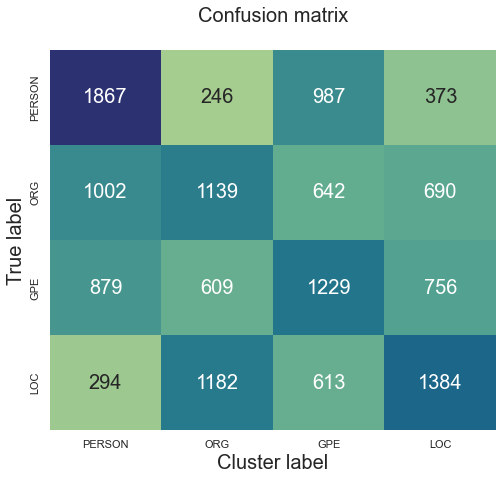

In [21]:
# re-order confusion matrix into a diagonal

for y_hat in range(len(confusion_matrix)):
    max = np.argmax(confusion_matrix[y_hat])
    confusion_matrix.T[[y_hat, max]] = confusion_matrix.T[[max, y_hat]]
plt.figure(figsize=(8,7))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("crest", as_cmap=True),
    cbar=False,
    annot_kws={"size": 20},
    xticklabels=entity_labels,
    yticklabels=entity_labels,
    )
plt.title("Confusion matrix\n", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Cluster label', fontsize=20)
plt.show()

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123, n_iter=10000, learning_rate='auto')
z = tsne.fit_transform(x)



c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13892 samples in 0.007s...
[t-SNE] Computed neighbors for 13892 samples in 0.966s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13892
[t-SNE] Computed conditional probabilities for sample 2000 / 13892
[t-SNE] Computed conditional probabilities for sample 3000 / 13892
[t-SNE] Computed conditional probabilities for sample 4000 / 13892
[t-SNE] Computed conditional probabilities for sample 5000 / 13892
[t-SNE] Computed conditional probabilities for sample 6000 / 13892
[t-SNE] Computed conditional probabilities for sample 7000 / 13892
[t-SNE] Computed conditional probabilities for sample 8000 / 13892
[t-SNE] Computed conditional probabilities for sample 9000 / 13892
[t-SNE] Computed conditional probabilities for sample 10000 / 13892
[t-SNE] Computed conditional probabilities for sample 11000 / 13892
[t-SNE] Computed conditional probabilities for sample 12000 / 13892
[t-SNE] Computed conditional probabilities for sam

In [23]:
df_tsne = pd.DataFrame()
df_tsne["y"] = y_pred
df_tsne["comp-1"] = z[:,0]
df_tsne["comp-2"] = z[:,1]
plt.figure(figsize=(18,14))
sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne.y.tolist(),
                palette=sns.color_palette("hls", len(entity_labels)),
                data=df_tsne).set(title="Labelled embeddings T-SNE projection") 

NameError: name 'pd' is not defined

: 

In [ ]:
print("Done")

Done


### Break down Accuracy metric

linear assignment- [Munkres' Assignment Algorithm](http://csclab.murraystate.edu/~bob.pilgrim/445/munkres.html)

In [44]:
from linear_assignment import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

TypeError: 'numpy.int64' object is not callable

In [32]:
w

array([[   7,   17,    2,  111,    0, 6102,  229,    2,   63,   17],
       [   1,   25,   41,   55,    5,    2,    0, 6992,    7,  116],
       [   8,   11,    8,   18,  108,   23,    0,   91,  105, 6488],
       [  29,    4,   38,    4,   31,   35, 6569,    0,   15,    6],
       [  42,   46,   65,   64,    6,   19,   10,    4, 6488,   63],
       [   0, 7638,    7,    4,    4,    3,   12,   27,   22,    9],
       [6798,    1,   25,    2,    6,   18,   35,    7,   13,   29],
       [   1,   27,   35, 6759,    0,   89,    0,    3,   64,  121],
       [  10,   13,   62,    1, 6648,   10,   17,   62,   13,  103],
       [   7,   95, 6707,  123,   16,   12,    4,  105,   35,    6]],
      dtype=int64)

In [33]:
ind

array([[0, 5],
       [1, 7],
       [2, 9],
       [3, 6],
       [4, 8],
       [5, 1],
       [6, 0],
       [7, 3],
       [8, 4],
       [9, 2]])

In [34]:
w.argmax(1)

array([5, 7, 9, 6, 8, 1, 0, 3, 4, 2], dtype=int64)

## Experimental
Convolutional auto encoder.

## Model to train clustering and autoencoder at same time
Multiple outputs model.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
from time import time
from keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import metrics

In [11]:
autoencoder, encoder = autoencoder_model(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

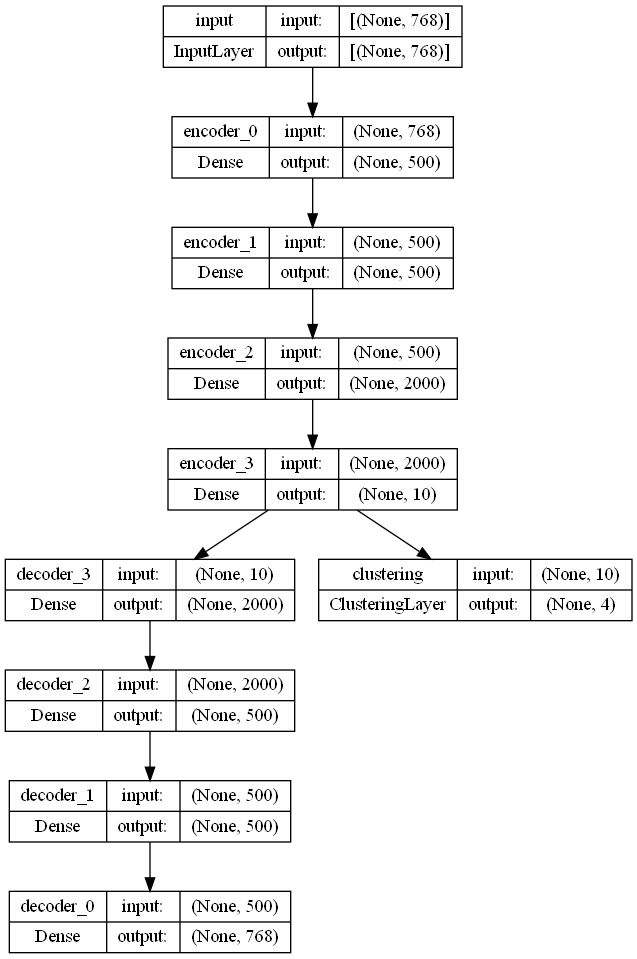

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


### Initialize cluster centers using k-means

In [13]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

7/7 [==============================] - 1s 1ms/step


c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [14]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [23]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            accu = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print(
                f"Iter {ite}: acc = {accu:.5f}, "
                f"nmi = {nmi:.5f}, ari = {ari:.5f}"
                f" ; loss={loss}")
        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

Iter 0: acc = 0.42157, nmi = 0.18652, ari = 0.11762  ; loss= 0
Iter 140: acc = 0.42647, nmi = 0.18673, ari = 0.12350  ; loss= [0.00369 0.00391 0.0033 ]
Iter 280: acc = 0.42647, nmi = 0.18073, ari = 0.12080  ; loss= [0.0029  0.01868 0.00103]
Iter 420: acc = 0.44118, nmi = 0.19519, ari = 0.13638  ; loss= [0.00319 0.02573 0.00061]
Iter 560: acc = 0.44118, nmi = 0.21428, ari = 0.14889  ; loss= [0.00346 0.02908 0.00055]
Iter 700: acc = 0.44118, nmi = 0.21428, ari = 0.14889  ; loss= [0.00334 0.02679 0.00066]
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


### Load the clustering model trained weights

In [24]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### Final Evaluation

In [25]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.44118, nmi = 0.21428, ari = 0.14889  ; loss= [0.00334 0.02679 0.00066]


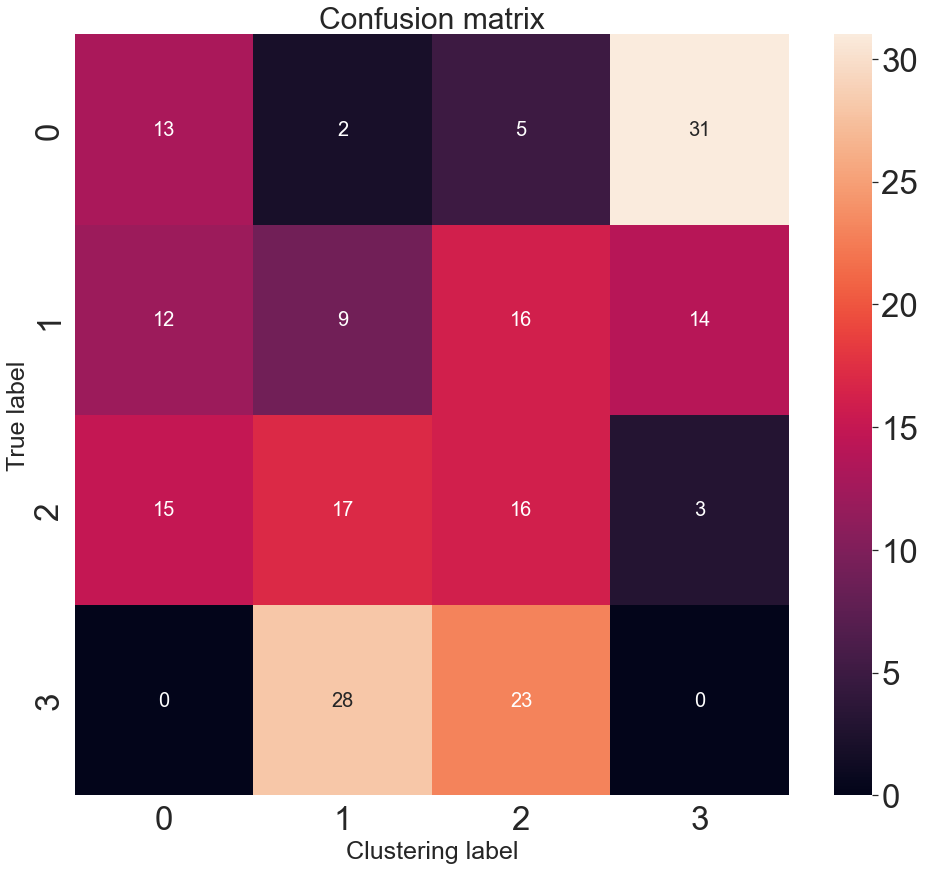

In [26]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [19]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
from time import time
from keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import metrics

In [20]:
from data import load_data

x, y, mapping = load_data(10000)
n_clusters = len(np.unique(y))
x.shape

Loading ./data/conll_spacy_10000.pkl
Done: (10074, 772)
{1: 'ORG', 0: 'PERSON', 2: 'GPE', 3: 'LOC'}
x: (13892, 768), y: (13892,)


(13892, 768)

c:\Users\Will\Anaconda3\envs\tf-27\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [22]:

def autoencoder_model(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [23]:
autoencoder, encoder = autoencoder_model(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

NameError: name 'ClusteringLayer' is not defined

In [24]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

NameError: name 'model' is not defined

### Initialize cluster centers using k-means

In [6]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

435/435 [==============================] - 1s 795us/step


NameError: name 'model' is not defined

In [34]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [44]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training


In [45]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            accu = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print(
                f"Iter {ite}: acc = {accu:.5f}, "
                f"nmi = {nmi:.5f}, ari = {ari:.5f}"
                f" ; loss={loss}")

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

Iter 0: acc = 0.35992, nmi = 0.05187, ari = 0.04329  ; loss= 0
Iter 140: acc = 0.35531, nmi = 0.04712, ari = 0.03949  ; loss= [0.05444 0.0192  0.05252]
Iter 280: acc = 0.35596, nmi = 0.04484, ari = 0.03893  ; loss= [0.05401 0.03414 0.05059]
Iter 420: acc = 0.35625, nmi = 0.04117, ari = 0.03789  ; loss= [0.07023 0.10488 0.05974]
Iter 560: acc = 0.35992, nmi = 0.04309, ari = 0.03993  ; loss= [0.0571  0.06487 0.05061]
Iter 700: acc = 0.34869, nmi = 0.03633, ari = 0.03273  ; loss= [0.06637 0.0998  0.05639]
Iter 840: acc = 0.34941, nmi = 0.03745, ari = 0.03378  ; loss= [0.05968 0.07527 0.05215]
Iter 980: acc = 0.34999, nmi = 0.03861, ari = 0.03457  ; loss= [0.02828 0.10186 0.0181 ]
Iter 1120: acc = 0.35006, nmi = 0.03882, ari = 0.03435  ; loss= [0.05069 0.06932 0.04376]
Iter 1260: acc = 0.34905, nmi = 0.03818, ari = 0.03390  ; loss= [0.01583 0.06495 0.00933]
Iter 1400: acc = 0.34826, nmi = 0.03787, ari = 0.03360  ; loss= [0.0557  0.06394 0.0493 ]
Iter 1540: acc = 0.34876, nmi = 0.03813, ari

### Load the clustering model trained weights

In [60]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### Final Evaluation

In [46]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.34891, nmi = 0.03800, ari = 0.03375  ; loss= [0.04786 0.04448 0.04341]


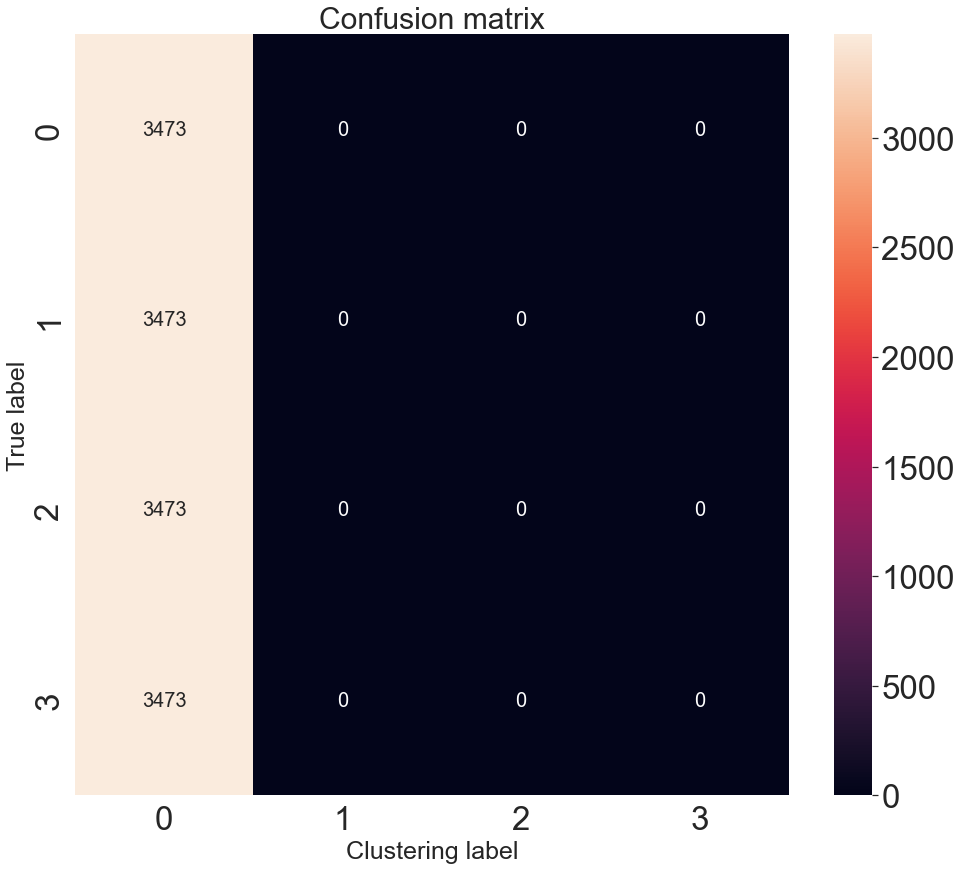

In [62]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()